### Introduction

New York City is the largest city in the United States, which has a long history and a lot of international immigrants. If one person is new to New York City, he/she may want to find the best restaurant to have a great experience in this beuautiful city. But how can we find the best restaurant and where is it?

This final project will foucs on exploring the best locations for Korean restaurants throughout the city of New York. Also, as with any business, if you are an investor, to open a new restaurant will need a lot of considerations and is more complicated than they think. Especially, the location of the restaurant is one of the most important factors that will affect whether it will succeed or not. Hence, this project will try to answer the questions:
1. Where should the investor open a Korean Restaurant? 
2. Where should I go If I want great Korean food?

### Data

In order to answer the above questions, we will need the data on New York City neighborhoods, boroughs to include boundaries, latitude, longitude, restaurants, and restaurant ratings and tips. 

New York City data containing the neighborhoods and boroughs, latitudes, and longitudes will be obtained from the data source: https://cocl.us/new_york_dataset

Other data related to locations and quality of Korean restaurants will be obtained via the FourSquare API.

### Methodology



• Data will be collected from https://cocl.us/new_york_dataset and cleaned and processed into a dataframe.

• Utilize FourSquare with venues and then filtered by Korean restaurants. Ratings, tips, and likes by users will be counted and added to the dataframe.

• Data will be sorted based on rankings.

• Finally, the data be will be visually assessed using graphing from Python libraries.

### Problem 

1. What is / are the best location(s) for Korean restaurants in New York City?
2. In what Neighborhood and/or borough should the investor open a Korean restaurants to have the best chance of being successful?
3. Where would I go in New York City to have the best Korean food?

In [2]:
pip install geopy 

Note: you may need to restart the kernel to use updated packages.


### Import Libraries

In [1]:
import numpy as np 
import pandas as pd 
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)
import os
import folium 
from geopy.geocoders import Nominatim # convert an address into latitude and longitude values
import requests 
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import matplotlib.colors as colors
%matplotlib inline
import seaborn as sns

### Foursquare ID

In [36]:
CLIENT_ID = 'LT30UFDL0WQUHJWBR01JRM1R3DPAFPJYNBGFGFMQOGHSWIQB' # your Foursquare ID
CLIENT_SECRET = 'Y5TRLQIEZLLGK02BMOXJA4RGHICII10K31PRCIGXZDKLFN3D' # your Foursquare Secret
VERSION = '20200601' # Foursquare API version

### Now let's define the functions we are going to use later in this project

In [39]:
def geo_location(address):
    # get geo location of address
    geolocator = Nominatim(user_agent="foursquare_agent")
    location = geolocator.geocode(address)
    latitude = location.latitude
    longitude = location.longitude
    return latitude,longitude


def get_venues(lat,lng):
    #set variables
    radius=400
    LIMIT=100
    #url to fetch data from foursquare api
    url = 'https://api.foursquare.com/v2/venues/explore?&client_id={}&client_secret={}&v={}&ll={},{}&radius={}&limit={}'.format(
            CLIENT_ID, 
            CLIENT_SECRET, 
            VERSION, 
            lat, 
            lng, 
            radius, 
            LIMIT)
    # get all the data
    results = requests.get(url).json()
    venue_data=results['response']['groups'][0]['items']
    venue_details=[]
    for row in venue_data:
        try:
            venue_id=row['venue']['id']
            venue_name=row['venue']['name']
            venue_category=row['venue']['categories'][0]['name']
            venue_details.append([venue_id,venue_name,venue_category])
        except KeyError:
            pass
    column_names=['ID','Name','Category']
    df = pd.DataFrame(venue_details,columns=column_names)
    return df


def get_venue_details(venue_id):
    #url to fetch data from foursquare api
    url = 'https://api.foursquare.com/v2/venues/{}?&client_id={}&client_secret={}&v={}'.format(
            venue_id,
            CLIENT_ID, 
            CLIENT_SECRET, 
            VERSION)
    # get all the data
    results = requests.get(url).json()
    print(results)
    venue_data=results['response']['venue']
    venue_details=[]
    try:
        venue_id=venue_data['id']
        venue_name=venue_data['name']
        venue_likes=venue_data['likes']['count']
        venue_rating=venue_data['rating']
        venue_tips=venue_data['tips']['count']
        venue_details.append([venue_id,venue_name,venue_likes,venue_rating,venue_tips])
    except KeyError:
        pass
    column_names=['ID','Name','Likes','Rating','Tips']
    df = pd.DataFrame(venue_details,columns=column_names)
    return df


def get_new_york_data():
    url='https://cocl.us/new_york_dataset'
    resp=requests.get(url).json()
    # all data is present in features label
    features=resp['features']
    # define the dataframe columns
    column_names = ['Borough', 'Neighborhood', 'Latitude', 'Longitude'] 
    # instantiate the dataframe
    new_york_data = pd.DataFrame(columns=column_names)
    for data in features:
        borough = data['properties']['borough'] 
        neighborhood_name = data['properties']['name']
        neighborhood_latlon = data['geometry']['coordinates']
        neighborhood_lat = neighborhood_latlon[1]
        neighborhood_lon = neighborhood_latlon[0]
        new_york_data = new_york_data.append({'Borough': borough,
                                          'Neighborhood': neighborhood_name,
                                          'Latitude': neighborhood_lat,
                                          'Longitude': neighborhood_lon}, ignore_index=True)
    return new_york_data

### Now let's use the above codes to get our initial NYC data

In [14]:
ny_data = get_new_york_data()
ny_data.head()

,Borough,Neighborhood,Latitude,Longitude
0,Bronx,Wakefield,40.894705,-73.847201
1,Bronx,Co-op City,40.874294,-73.829939
2,Bronx,Eastchester,40.887556,-73.827806
3,Bronx,Fieldston,40.895437,-73.905643
4,Bronx,Riverdale,40.890834,-73.912585


### Data Analysis

First, we explore how many numbers of neighborhoods perborough in NYC

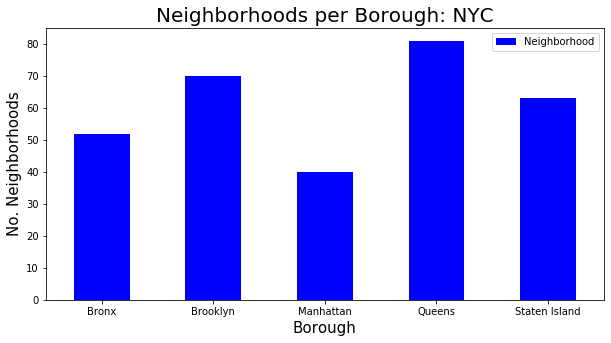

In [15]:
clr = "blue"
ny_data.groupby('Borough')['Neighborhood'].count().plot.bar(figsize=(10,5), color=clr)
plt.title('Neighborhoods per Borough: NYC', fontsize = 20)
plt.xlabel('Borough', fontsize = 15)
plt.ylabel('No. Neighborhoods',fontsize = 15)
plt.xticks(rotation = 'horizontal')
plt.legend()
plt.show()

Then, we analyze how many Korean restaurants there are in each neighborhood and borough.

In [25]:
column_names=['Borough', 'Neighborhood', 'ID','Name']
korean_rest_ny=pd.DataFrame(columns=column_names)
count=1
for row in ny_data.values.tolist():
    Borough, Neighborhood, Latitude, Longitude=row
    venues = get_venues(Latitude,Longitude)
    korean_restaurants=venues[venues['Category']=='Korean Restaurant']   
    print('(',count,'/',len(ny_data),')','Korean Restaurants in '+Neighborhood+', '+Borough+':'+str(len(korean_restaurants)))
    for resturant_detail in korean_restaurants.values.tolist():
        id, name , category=resturant_detail
        korean_rest_ny = korean_rest_ny.append({'Borough': Borough,
                                                'Neighborhood': Neighborhood, 
                                                'ID': id,
                                                'Name' : name
                                               }, ignore_index=True)
    count+=1

( 1 / 306 ) Korean Restaurants in Wakefield, Bronx:0
( 2 / 306 ) Korean Restaurants in Co-op City, Bronx:0
( 3 / 306 ) Korean Restaurants in Eastchester, Bronx:0
( 4 / 306 ) Korean Restaurants in Fieldston, Bronx:0
( 5 / 306 ) Korean Restaurants in Riverdale, Bronx:0
( 6 / 306 ) Korean Restaurants in Kingsbridge, Bronx:0
( 7 / 306 ) Korean Restaurants in Marble Hill, Manhattan:0
( 8 / 306 ) Korean Restaurants in Woodlawn, Bronx:0
( 9 / 306 ) Korean Restaurants in Norwood, Bronx:0
( 10 / 306 ) Korean Restaurants in Williamsbridge, Bronx:0
( 11 / 306 ) Korean Restaurants in Baychester, Bronx:0
( 12 / 306 ) Korean Restaurants in Pelham Parkway, Bronx:0
( 13 / 306 ) Korean Restaurants in City Island, Bronx:0
( 14 / 306 ) Korean Restaurants in Bedford Park, Bronx:0
( 15 / 306 ) Korean Restaurants in University Heights, Bronx:0
( 16 / 306 ) Korean Restaurants in Morris Heights, Bronx:0
( 17 / 306 ) Korean Restaurants in Fordham, Bronx:0
( 18 / 306 ) Korean Restaurants in East Tremont, Bronx:

( 141 / 306 ) Korean Restaurants in Sunnyside, Queens:0
( 142 / 306 ) Korean Restaurants in East Elmhurst, Queens:0
( 143 / 306 ) Korean Restaurants in Maspeth, Queens:0
( 144 / 306 ) Korean Restaurants in Ridgewood, Queens:1
( 145 / 306 ) Korean Restaurants in Glendale, Queens:0
( 146 / 306 ) Korean Restaurants in Rego Park, Queens:0
( 147 / 306 ) Korean Restaurants in Woodhaven, Queens:0
( 148 / 306 ) Korean Restaurants in Ozone Park, Queens:0
( 149 / 306 ) Korean Restaurants in South Ozone Park, Queens:0
( 150 / 306 ) Korean Restaurants in College Point, Queens:0
( 151 / 306 ) Korean Restaurants in Whitestone, Queens:0
( 152 / 306 ) Korean Restaurants in Bayside, Queens:1
( 153 / 306 ) Korean Restaurants in Auburndale, Queens:0
( 154 / 306 ) Korean Restaurants in Little Neck, Queens:3
( 155 / 306 ) Korean Restaurants in Douglaston, Queens:0
( 156 / 306 ) Korean Restaurants in Glen Oaks, Queens:0
( 157 / 306 ) Korean Restaurants in Bellerose, Queens:0
( 158 / 306 ) Korean Restaurants

( 276 / 306 ) Korean Restaurants in Stuyvesant Town, Manhattan:0
( 277 / 306 ) Korean Restaurants in Flatiron, Manhattan:0
( 278 / 306 ) Korean Restaurants in Sunnyside Gardens, Queens:2
( 279 / 306 ) Korean Restaurants in Blissville, Queens:0
( 280 / 306 ) Korean Restaurants in Fulton Ferry, Brooklyn:0
( 281 / 306 ) Korean Restaurants in Vinegar Hill, Brooklyn:0
( 282 / 306 ) Korean Restaurants in Weeksville, Brooklyn:0
( 283 / 306 ) Korean Restaurants in Broadway Junction, Brooklyn:0
( 284 / 306 ) Korean Restaurants in Dumbo, Brooklyn:0
( 285 / 306 ) Korean Restaurants in Manor Heights, Staten Island:0
( 286 / 306 ) Korean Restaurants in Willowbrook, Staten Island:0
( 287 / 306 ) Korean Restaurants in Sandy Ground, Staten Island:0
( 288 / 306 ) Korean Restaurants in Egbertville, Staten Island:0
( 289 / 306 ) Korean Restaurants in Roxbury, Queens:0
( 290 / 306 ) Korean Restaurants in Homecrest, Brooklyn:0
( 291 / 306 ) Korean Restaurants in Middle Village, Queens:0
( 292 / 306 ) Korea

In [26]:
# Save the information to .csv file 
korean_rest_ny.to_csv('korean_rest_ny_tocsv1.csv')

In [27]:
# read csv file
korean_ny = pd.read_csv('korean_rest_ny_tocsv1.csv')
korean_rest_ny.head()

,Borough,Neighborhood,ID,Name
0,Brooklyn,Brighton Beach,4c9d5c0303133704a96f5ed5,Cafe At Your Mother-in-Law
1,Brooklyn,Prospect Heights,4fa162e0e4b0badc81404a51,Kimchi Grill
2,Brooklyn,Williamsburg,52bf3053498e754b09a440b5,Dotory
3,Brooklyn,Downtown,5b01ecd28cdedf00245af923,BonChon Chicken
4,Brooklyn,North Side,59c295349b04732c1d51aa52,Kimbap Lab


In [28]:
korean_rest_ny.shape

(59, 4)

We have 59 Korean restaurants in New York City. We then plot the No. of Korean restaurants per borough.

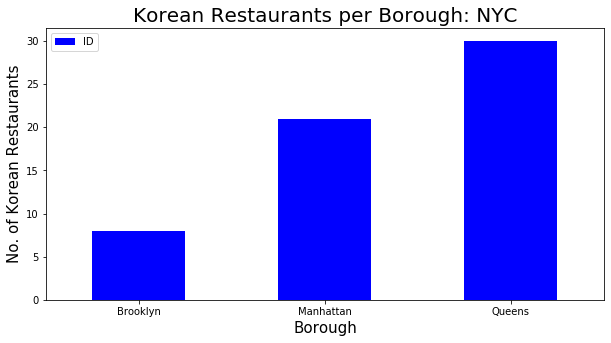

In [30]:
korean_rest_ny.groupby('Borough')['ID'].count().plot.bar(figsize=(10,5), color=clr)
plt.title('Korean Restaurants per Borough: NYC', fontsize = 20)
plt.xlabel('Borough', fontsize = 15)
plt.ylabel('No. of Korean Restaurants', fontsize=15)
plt.xticks(rotation = 'horizontal')
plt.legend()
plt.show()

From the above figure, we know that Queens has the highest number of Korean restaurants. 

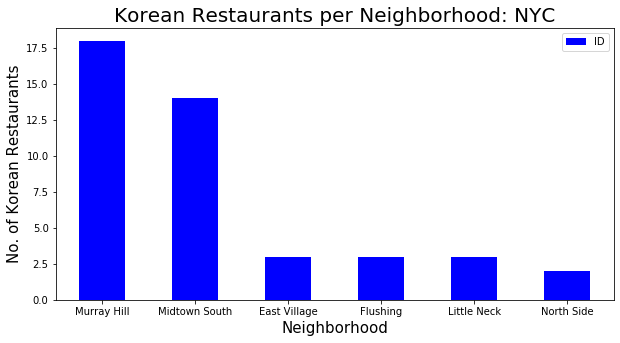

In [31]:
NOofNeigh = 6 # top number for graphing 
korean_rest_ny.groupby('Neighborhood')['ID'].count().nlargest(NOofNeigh).plot.bar(figsize=(10,5), color=clr)
plt.title('Korean Restaurants per Neighborhood: NYC', fontsize = 20)
plt.xlabel('Neighborhood', fontsize = 15)
plt.ylabel('No. of Korean Restaurants', fontsize=15)
plt.xticks(rotation = 'horizontal')
plt.legend()
plt.show()

Additionally, we see how many restaurants the top 6 neighborhoods have. The neighborhood of Murray Hill has the highest number of Korean restaurants in all of NYC. So if you want to find a Korean restaurant, go to Murray Hill.
Now, we will continue the analysis of the rating, ranking, tips.

In [40]:
column_names=['Borough', 'Neighborhood', 'ID','Name','Likes','Rating','Tips']
korean_rest_stats_ny=pd.DataFrame(columns=column_names)
count=1
for row in korean_rest_ny.values.tolist():
    Borough,Neighborhood,ID,Name=row
    try:
        venue_details=get_venue_details(ID)
        print(venue_details)
        id,name,likes,rating,tips=venue_details.values.tolist()[0]
    except IndexError:
        print('No data available for id=',ID)
        # we will assign 0 value for these resturants as they may have been 
        #recently opened or details does not exist in FourSquare Database
        id,name,likes,rating,tips=[0]*5
    print('(',count,'/',len(korean_rest_ny),')','processed')
    korean_rest_stats_ny = korean_rest_stats_ny.append({'Borough': Borough,
                                                'Neighborhood': Neighborhood, 
                                                'ID': id,
                                                'Name' : name,
                                                'Likes' : likes,
                                                'Rating' : rating,
                                                'Tips' : tips
                                               }, ignore_index=True)
    count+=1
korean_rest_stats_ny.tail()

{'meta': {'code': 200, 'requestId': '5f29c211d79d8e396254b661'}, 'response': {'venue': {'id': '4c9d5c0303133704a96f5ed5', 'name': 'Cafe At Your Mother-in-Law', 'contact': {'phone': '7189424088', 'formattedPhone': '(718) 942-4088', 'twitter': 'cafeaymil_ny'}, 'location': {'address': '3071 Brighton 4th St', 'lat': 40.57757524231774, 'lng': -73.96344895612154, 'labeledLatLngs': [{'label': 'display', 'lat': 40.57757524231774, 'lng': -73.96344895612154}, {'label': 'entrance', 'lat': 40.577515, 'lng': -73.963289}], 'postalCode': '11235', 'cc': 'US', 'city': 'Brooklyn', 'state': 'NY', 'country': 'United States', 'formattedAddress': ['3071 Brighton 4th St', 'Brooklyn, NY 11235', 'United States']}, 'canonicalUrl': 'https://foursquare.com/v/cafe-at-your-motherinlaw/4c9d5c0303133704a96f5ed5', 'categories': [{'id': '4bf58dd8d48988d113941735', 'name': 'Korean Restaurant', 'pluralName': 'Korean Restaurants', 'shortName': 'Korean', 'icon': {'prefix': 'https://ss3.4sqi.net/img/categories_v2/food/korea

{'meta': {'code': 200, 'requestId': '5f29c209dbd14a7651540ea5'}, 'response': {'venue': {'id': '4fa162e0e4b0badc81404a51', 'name': 'Kimchi Grill', 'contact': {'phone': '7183601839', 'formattedPhone': '(718) 360-1839'}, 'location': {'address': '766 Washington Ave', 'crossStreet': 'btwn Sterling & Park Pl.', 'lat': 40.67512957407338, 'lng': -73.96324476804656, 'labeledLatLngs': [{'label': 'display', 'lat': 40.67512957407338, 'lng': -73.96324476804656}], 'postalCode': '11238', 'cc': 'US', 'city': 'Brooklyn', 'state': 'NY', 'country': 'United States', 'formattedAddress': ['766 Washington Ave (btwn Sterling & Park Pl.)', 'Brooklyn, NY 11238', 'United States']}, 'canonicalUrl': 'https://foursquare.com/v/kimchi-grill/4fa162e0e4b0badc81404a51', 'categories': [{'id': '4bf58dd8d48988d113941735', 'name': 'Korean Restaurant', 'pluralName': 'Korean Restaurants', 'shortName': 'Korean', 'icon': {'prefix': 'https://ss3.4sqi.net/img/categories_v2/food/korean_', 'suffix': '.png'}, 'primary': True}], 'ver

{'meta': {'code': 200, 'requestId': '5f29c23585d1da39f9683669'}, 'response': {'venue': {'id': '52bf3053498e754b09a440b5', 'name': 'Dotory', 'contact': {'phone': '7185991399', 'formattedPhone': '(718) 599-1399', 'facebook': '474808822615656', 'facebookUsername': 'dotorybk', 'facebookName': 'Dotory'}, 'location': {'address': '353 Broadway', 'lat': 40.707729602666035, 'lng': -73.95577850789788, 'labeledLatLngs': [{'label': 'display', 'lat': 40.707729602666035, 'lng': -73.95577850789788}], 'postalCode': '11211', 'cc': 'US', 'city': 'Brooklyn', 'state': 'NY', 'country': 'United States', 'formattedAddress': ['353 Broadway', 'Brooklyn, NY 11211', 'United States']}, 'canonicalUrl': 'https://foursquare.com/v/dotory/52bf3053498e754b09a440b5', 'categories': [{'id': '4bf58dd8d48988d113941735', 'name': 'Korean Restaurant', 'pluralName': 'Korean Restaurants', 'shortName': 'Korean', 'icon': {'prefix': 'https://ss3.4sqi.net/img/categories_v2/food/korean_', 'suffix': '.png'}, 'primary': True}], 'verifi

{'meta': {'code': 200, 'requestId': '5f29c25258005e361f7bbc50'}, 'response': {'venue': {'id': '5b01ecd28cdedf00245af923', 'name': 'BonChon Chicken', 'contact': {'twitter': 'bonchon', 'instagram': 'bonchonchicken', 'facebook': '134407269949073', 'facebookUsername': 'BonchonChickenOfficial', 'facebookName': 'Bonchon Chicken'}, 'location': {'address': '72 Willoughby St', 'crossStreet': 'at Lawrence St', 'lat': 40.692153690953354, 'lng': -73.98599977340788, 'labeledLatLngs': [{'label': 'display', 'lat': 40.692153690953354, 'lng': -73.98599977340788}], 'postalCode': '11201', 'cc': 'US', 'city': 'Brooklyn', 'state': 'NY', 'country': 'United States', 'formattedAddress': ['72 Willoughby St (at Lawrence St)', 'Brooklyn, NY 11201', 'United States']}, 'canonicalUrl': 'https://foursquare.com/v/bonchon-chicken/5b01ecd28cdedf00245af923', 'categories': [{'id': '4bf58dd8d48988d113941735', 'name': 'Korean Restaurant', 'pluralName': 'Korean Restaurants', 'shortName': 'Korean', 'icon': {'prefix': 'https:

{'meta': {'code': 200, 'requestId': '5f29c1a6f773f578f1998adb'}, 'response': {'venue': {'id': '59c295349b04732c1d51aa52', 'name': 'Kimbap Lab', 'contact': {'phone': '7187342321', 'formattedPhone': '(718) 734-2321'}, 'location': {'address': '238 Bedford Avenue', 'lat': 40.71616, 'lng': -73.95953, 'labeledLatLngs': [{'label': 'display', 'lat': 40.71616, 'lng': -73.95953}], 'postalCode': '11249', 'cc': 'US', 'city': 'Brooklyn', 'state': 'NY', 'country': 'United States', 'formattedAddress': ['238 Bedford Avenue', 'Brooklyn, NY 11249', 'United States']}, 'canonicalUrl': 'https://foursquare.com/v/kimbap-lab/59c295349b04732c1d51aa52', 'categories': [{'id': '4bf58dd8d48988d113941735', 'name': 'Korean Restaurant', 'pluralName': 'Korean Restaurants', 'shortName': 'Korean', 'icon': {'prefix': 'https://ss3.4sqi.net/img/categories_v2/food/korean_', 'suffix': '.png'}, 'primary': True}, {'id': '56aa371be4b08b9a8d57350b', 'name': 'Food Stand', 'pluralName': 'Food Stands', 'shortName': 'Food Stand', 'i

{'meta': {'code': 200, 'requestId': '5f29c03c1474c964131d0df6'}, 'response': {'venue': {'id': '43db5698f964a5208a2e1fe3', 'name': 'Dokebi', 'contact': {'phone': '7187821424', 'formattedPhone': '(718) 782-1424', 'twitter': 'dokebibbq'}, 'location': {'address': '199 Grand St', 'crossStreet': 'btwn Bedford & Driggs Ave.', 'lat': 40.714185631114006, 'lng': -73.96033203612464, 'labeledLatLngs': [{'label': 'display', 'lat': 40.714185631114006, 'lng': -73.96033203612464}, {'label': 'entrance', 'lat': 40.714198, 'lng': -73.960309}], 'postalCode': '11211', 'cc': 'US', 'city': 'Brooklyn', 'state': 'NY', 'country': 'United States', 'formattedAddress': ['199 Grand St (btwn Bedford & Driggs Ave.)', 'Brooklyn, NY 11211', 'United States']}, 'canonicalUrl': 'https://foursquare.com/v/dokebi/43db5698f964a5208a2e1fe3', 'categories': [{'id': '4bf58dd8d48988d113941735', 'name': 'Korean Restaurant', 'pluralName': 'Korean Restaurants', 'shortName': 'Korean', 'icon': {'prefix': 'https://ss3.4sqi.net/img/categ

{'meta': {'code': 200, 'requestId': '5f29c08df7854f0f27a88461'}, 'response': {'venue': {'id': '4b240e1af964a5200a6024e3', 'name': 'Kimchee Korean Cuisine', 'contact': {'phone': '7185675741', 'formattedPhone': '(718) 567-5741'}, 'location': {'address': '9324 3rd Ave', 'crossStreet': 'at 94th St', 'lat': 40.61797065682916, 'lng': -74.03344650023448, 'labeledLatLngs': [{'label': 'display', 'lat': 40.61797065682916, 'lng': -74.03344650023448}, {'label': 'entrance', 'lat': 40.618097, 'lng': -74.033403}], 'postalCode': '11209', 'cc': 'US', 'city': 'Brooklyn', 'state': 'NY', 'country': 'United States', 'formattedAddress': ['9324 3rd Ave (at 94th St)', 'Brooklyn, NY 11209', 'United States']}, 'canonicalUrl': 'https://foursquare.com/v/kimchee-korean-cuisine/4b240e1af964a5200a6024e3', 'categories': [{'id': '4bf58dd8d48988d113941735', 'name': 'Korean Restaurant', 'pluralName': 'Korean Restaurants', 'shortName': 'Korean', 'icon': {'prefix': 'https://ss3.4sqi.net/img/categories_v2/food/korean_', 's

{'meta': {'code': 200, 'requestId': '5f29c17caf4413115c3b6e71'}, 'response': {'venue': {'id': '5dbcafa6e40280000819d3db', 'name': 'Kochi', 'contact': {}, 'location': {'address': '652 10th Ave', 'crossStreet': '46th Street', 'lat': 40.76203, 'lng': -73.99355, 'labeledLatLngs': [{'label': 'display', 'lat': 40.76203, 'lng': -73.99355}], 'postalCode': '10036', 'cc': 'US', 'neighborhood': "Hell's Kitchen", 'city': 'New York', 'state': 'NY', 'country': 'United States', 'formattedAddress': ['652 10th Ave (46th Street)', 'New York, NY 10036', 'United States']}, 'canonicalUrl': 'https://foursquare.com/v/kochi/5dbcafa6e40280000819d3db', 'categories': [{'id': '4bf58dd8d48988d113941735', 'name': 'Korean Restaurant', 'pluralName': 'Korean Restaurants', 'shortName': 'Korean', 'icon': {'prefix': 'https://ss3.4sqi.net/img/categories_v2/food/korean_', 'suffix': '.png'}, 'primary': True}], 'verified': False, 'stats': {'tipCount': 4}, 'url': 'http://kochinyc.com', 'price': {'tier': 2, 'message': 'Moderat

0  578bec6c498e3150fc369f3b  Thursday Kitchen    287     9.0    73
( 10 / 59 ) processed
{'meta': {'code': 200, 'requestId': '5f29c265780c3370713883b6'}, 'response': {'venue': {'id': '5dec54b8f93ca90007806f97', 'name': 'Mokyo', 'contact': {}, 'location': {'address': '109 Saint Marks Pl', 'lat': 40.727179, 'lng': -73.984056, 'labeledLatLngs': [{'label': 'display', 'lat': 40.727179, 'lng': -73.984056}, {'label': 'entrance', 'lat': 40.727122, 'lng': -73.983949}], 'postalCode': '10009', 'cc': 'US', 'city': 'New York', 'state': 'NY', 'country': 'United States', 'formattedAddress': ['109 Saint Marks Pl', 'New York, NY 10009', 'United States']}, 'canonicalUrl': 'https://foursquare.com/v/mokyo/5dec54b8f93ca90007806f97', 'categories': [{'id': '4bf58dd8d48988d113941735', 'name': 'Korean Restaurant', 'pluralName': 'Korean Restaurants', 'shortName': 'Korean', 'icon': {'prefix': 'https://ss3.4sqi.net/img/categories_v2/food/korean_', 'suffix': '.png'}, 'primary': True}], 'verified': False, 'stats': 

( 11 / 59 ) processed


{'meta': {'code': 200, 'requestId': '5f29c1d1f598007f3008e0ca'}, 'response': {'venue': {'id': '54cd73be498e9ab78644ab32', 'name': 'Oiji', 'contact': {'phone': '6467679050', 'formattedPhone': '(646) 767-9050', 'instagram': 'oijinyc'}, 'location': {'address': '119 1st Ave', 'lat': 40.727168125595306, 'lng': -73.98564524259254, 'labeledLatLngs': [{'label': 'display', 'lat': 40.727168125595306, 'lng': -73.98564524259254}, {'label': 'entrance', 'lat': 40.727239, 'lng': -73.985773}], 'postalCode': '10003', 'cc': 'US', 'neighborhood': 'East Village', 'city': 'New York', 'state': 'NY', 'country': 'United States', 'formattedAddress': ['119 1st Ave', 'New York, NY 10003', 'United States']}, 'canonicalUrl': 'https://foursquare.com/v/oiji/54cd73be498e9ab78644ab32', 'categories': [{'id': '4bf58dd8d48988d113941735', 'name': 'Korean Restaurant', 'pluralName': 'Korean Restaurants', 'shortName': 'Korean', 'icon': {'prefix': 'https://ss3.4sqi.net/img/categories_v2/food/korean_', 'suffix': '.png'}, 'prim

{'meta': {'code': 200, 'requestId': '5f29bfd1fdaeb56b6edf160e'}, 'response': {'venue': {'id': '4e67f1c7d16433b90090c8f3', 'name': 'Jungsik', 'contact': {'phone': '2122190900', 'formattedPhone': '(212) 219-0900', 'twitter': 'jungsikdang'}, 'location': {'address': '2 Harrison St', 'crossStreet': 'at Hudson St.', 'lat': 40.718694630954566, 'lng': -74.00906972656956, 'labeledLatLngs': [{'label': 'display', 'lat': 40.718694630954566, 'lng': -74.00906972656956}, {'label': 'entrance', 'lat': 40.718744, 'lng': -74.009072}], 'postalCode': '10013', 'cc': 'US', 'city': 'New York', 'state': 'NY', 'country': 'United States', 'formattedAddress': ['2 Harrison St (at Hudson St.)', 'New York, NY 10013', 'United States']}, 'canonicalUrl': 'https://foursquare.com/v/jungsik/4e67f1c7d16433b90090c8f3', 'categories': [{'id': '4bf58dd8d48988d113941735', 'name': 'Korean Restaurant', 'pluralName': 'Korean Restaurants', 'shortName': 'Korean', 'icon': {'prefix': 'https://ss3.4sqi.net/img/categories_v2/food/korean

{'meta': {'code': 200, 'requestId': '5f29c1eeee0a6101c512cbbb'}, 'response': {'venue': {'id': '59aa0677e17910245d942204', 'name': 'Jeju Noodle Bar', 'contact': {'phone': '2019213333', 'formattedPhone': '(201) 921-3333', 'instagram': 'jejunoodlebar'}, 'location': {'address': '679 Greenwich St', 'crossStreet': 'at Christopher St', 'lat': 40.73294539559912, 'lng': -74.0073655954149, 'labeledLatLngs': [{'label': 'display', 'lat': 40.73294539559912, 'lng': -74.0073655954149}, {'label': 'entrance', 'lat': 40.733036, 'lng': -74.007344}], 'postalCode': '10014', 'cc': 'US', 'city': 'New York', 'state': 'NY', 'country': 'United States', 'formattedAddress': ['679 Greenwich St (at Christopher St)', 'New York, NY 10014', 'United States']}, 'canonicalUrl': 'https://foursquare.com/v/jeju-noodle-bar/59aa0677e17910245d942204', 'categories': [{'id': '4bf58dd8d48988d113941735', 'name': 'Korean Restaurant', 'pluralName': 'Korean Restaurants', 'shortName': 'Korean', 'icon': {'prefix': 'https://ss3.4sqi.net

                         ID   Name  Likes  Rating  Tips
0  56a14149498e9983c0199038  Mokja     24     8.0     6
( 15 / 59 ) processed
{'meta': {'code': 200, 'requestId': '5f29c1937b92c17778c87c46'}, 'response': {'venue': {'id': '4ae39cb6f964a520439721e3', 'name': 'Debasaki', 'contact': {'phone': '7188866878', 'formattedPhone': '(718) 886-6878'}, 'location': {'address': '33-67 Farrington St', 'lat': 40.764851521130126, 'lng': -73.83176733519196, 'labeledLatLngs': [{'label': 'display', 'lat': 40.764851521130126, 'lng': -73.83176733519196}], 'postalCode': '11354', 'cc': 'US', 'city': 'Flushing', 'state': 'NY', 'country': 'United States', 'formattedAddress': ['33-67 Farrington St', 'Flushing, NY 11354', 'United States']}, 'canonicalUrl': 'https://foursquare.com/v/debasaki/4ae39cb6f964a520439721e3', 'categories': [{'id': '4bf58dd8d48988d113941735', 'name': 'Korean Restaurant', 'pluralName': 'Korean Restaurants', 'shortName': 'Korean', 'icon': {'prefix': 'https://ss3.4sqi.net/img/categories_

{'meta': {'code': 200, 'requestId': '5f29c1982c47b4597601c3f0'}, 'response': {'venue': {'id': '4aa5ae46f964a520264920e3', 'name': 'KumGangSan', 'contact': {'phone': '7184610909', 'formattedPhone': '(718) 461-0909'}, 'location': {'address': '13828 Northern Blvd', 'crossStreet': 'btwn Union St & Bowne St', 'lat': 40.763804403940526, 'lng': -73.82714310018443, 'labeledLatLngs': [{'label': 'display', 'lat': 40.763804403940526, 'lng': -73.82714310018443}], 'postalCode': '11354', 'cc': 'US', 'city': 'Flushing', 'state': 'NY', 'country': 'United States', 'formattedAddress': ['13828 Northern Blvd (btwn Union St & Bowne St)', 'Flushing, NY 11354', 'United States']}, 'canonicalUrl': 'https://foursquare.com/v/kumgangsan/4aa5ae46f964a520264920e3', 'categories': [{'id': '4bf58dd8d48988d113941735', 'name': 'Korean Restaurant', 'pluralName': 'Korean Restaurants', 'shortName': 'Korean', 'icon': {'prefix': 'https://ss3.4sqi.net/img/categories_v2/food/korean_', 'suffix': '.png'}, 'primary': True}], 'ver

{'meta': {'code': 200, 'requestId': '5f29c2c0a3822e313d6db5cb'}, 'response': {'venue': {'id': '58d070dbe309e12fbd02d163', 'name': 'Garlic to the Chicken', 'contact': {}, 'location': {'address': '66-92 Forest Ave', 'crossStreet': 'Putnam Avenue', 'lat': 40.705042, 'lng': -73.90219, 'labeledLatLngs': [{'label': 'display', 'lat': 40.705042, 'lng': -73.90219}], 'postalCode': '11385', 'cc': 'US', 'city': 'Ridgewood', 'state': 'NY', 'country': 'United States', 'formattedAddress': ['66-92 Forest Ave (Putnam Avenue)', 'Ridgewood, NY 11385', 'United States']}, 'canonicalUrl': 'https://foursquare.com/v/garlic-to-the-chicken/58d070dbe309e12fbd02d163', 'categories': [{'id': '4bf58dd8d48988d113941735', 'name': 'Korean Restaurant', 'pluralName': 'Korean Restaurants', 'shortName': 'Korean', 'icon': {'prefix': 'https://ss3.4sqi.net/img/categories_v2/food/korean_', 'suffix': '.png'}, 'primary': True}], 'verified': False, 'stats': {'tipCount': 2}, 'price': {'tier': 2, 'message': 'Moderate', 'currency': 

{'meta': {'code': 200, 'requestId': '5f29c17faf4413115c3b78c3'}, 'response': {'venue': {'id': '5b3badba3731ee002cc9e31a', 'name': 'Rolly', 'contact': {'phone': '7182290110', 'formattedPhone': '(718) 229-0110'}, 'location': {'address': '252-01 Northern Blvd', 'lat': 40.769881, 'lng': -73.736461, 'labeledLatLngs': [{'label': 'display', 'lat': 40.769881, 'lng': -73.736461}, {'label': 'entrance', 'lat': 40.769925, 'lng': -73.736396}], 'postalCode': '11362', 'cc': 'US', 'neighborhood': 'Little Neck', 'city': 'New York', 'state': 'NY', 'country': 'United States', 'formattedAddress': ['252-01 Northern Blvd', 'New York, NY 11362', 'United States']}, 'canonicalUrl': 'https://foursquare.com/v/rolly/5b3badba3731ee002cc9e31a', 'categories': [{'id': '4bf58dd8d48988d113941735', 'name': 'Korean Restaurant', 'pluralName': 'Korean Restaurants', 'shortName': 'Korean', 'icon': {'prefix': 'https://ss3.4sqi.net/img/categories_v2/food/korean_', 'suffix': '.png'}, 'primary': True}, {'id': '4bf58dd8d48988d1c7

( 22 / 59 ) processed
{'meta': {'code': 200, 'requestId': '5f29c297cc2d4f2e2019b61a'}, 'response': {'venue': {'id': '4c71ac6dad69b60c49ac81b9', 'name': 'Taeneung', 'contact': {'phone': '7186313636', 'formattedPhone': '(718) 631-3636'}, 'location': {'address': '248-25 northen Blvd', 'lat': 40.767535, 'lng': -73.73851195, 'labeledLatLngs': [{'label': 'display', 'lat': 40.767535, 'lng': -73.73851195}], 'postalCode': '11362', 'cc': 'US', 'city': 'Little Neck', 'state': 'NY', 'country': 'United States', 'formattedAddress': ['248-25 northen Blvd', 'Little Neck, NY 11362', 'United States']}, 'canonicalUrl': 'https://foursquare.com/v/taeneung/4c71ac6dad69b60c49ac81b9', 'categories': [{'id': '4bf58dd8d48988d113941735', 'name': 'Korean Restaurant', 'pluralName': 'Korean Restaurants', 'shortName': 'Korean', 'icon': {'prefix': 'https://ss3.4sqi.net/img/categories_v2/food/korean_', 'suffix': '.png'}, 'primary': True}], 'verified': False, 'stats': {'tipCount': 1}, 'price': {'tier': 2, 'message': 'Mo

{'meta': {'code': 200, 'requestId': '5f29c0bd72cee757fca4f30c'}, 'response': {'venue': {'id': '526c1acf11d288dc8354b7b9', 'name': 'Rolly Kimbab', 'contact': {'phone': '3474084172', 'formattedPhone': '(347) 408-4172'}, 'location': {'address': '61-23 Springfield Blvd', 'lat': 40.74853074631299, 'lng': -73.756334784455, 'labeledLatLngs': [{'label': 'display', 'lat': 40.74853074631299, 'lng': -73.756334784455}], 'postalCode': '11364', 'cc': 'US', 'city': 'Bayside', 'state': 'NY', 'country': 'United States', 'formattedAddress': ['61-23 Springfield Blvd', 'Bayside, NY 11364', 'United States']}, 'canonicalUrl': 'https://foursquare.com/v/rolly-kimbab/526c1acf11d288dc8354b7b9', 'categories': [{'id': '4bf58dd8d48988d113941735', 'name': 'Korean Restaurant', 'pluralName': 'Korean Restaurants', 'shortName': 'Korean', 'icon': {'prefix': 'https://ss3.4sqi.net/img/categories_v2/food/korean_', 'suffix': '.png'}, 'primary': True}], 'verified': False, 'stats': {'tipCount': 11}, 'url': 'http://rollykimbab

{'meta': {'code': 200, 'requestId': '5f29c037c8e3474a396369f5'}, 'response': {'venue': {'id': '4b830e44f964a520ebf430e3', 'name': 'Hahm Ji Bach - 함지박', 'contact': {'phone': '7184609289', 'formattedPhone': '(718) 460-9289'}, 'location': {'address': '40-11 149th Pl', 'lat': 40.763021787852146, 'lng': -73.81504155699612, 'labeledLatLngs': [{'label': 'display', 'lat': 40.763021787852146, 'lng': -73.81504155699612}], 'postalCode': '11354', 'cc': 'US', 'city': 'Flushing', 'state': 'NY', 'country': 'United States', 'formattedAddress': ['40-11 149th Pl', 'Flushing, NY 11354', 'United States']}, 'canonicalUrl': 'https://foursquare.com/v/hahm-ji-bach--%ED%95%A8%EC%A7%80%EB%B0%95/4b830e44f964a520ebf430e3', 'categories': [{'id': '4bf58dd8d48988d113941735', 'name': 'Korean Restaurant', 'pluralName': 'Korean Restaurants', 'shortName': 'Korean', 'icon': {'prefix': 'https://ss3.4sqi.net/img/categories_v2/food/korean_', 'suffix': '.png'}, 'primary': True}, {'id': '4bf58dd8d48988d1df931735', 'name': 'BB

{'meta': {'code': 200, 'requestId': '5f29c2814d87fd1d7c07e0e0'}, 'response': {'venue': {'id': '4b8f0931f964a520d04533e3', 'name': 'Mapo BBQ', 'contact': {'phone': '7188868292', 'formattedPhone': '(718) 886-8292'}, 'location': {'address': '14924 41st Ave', 'crossStreet': 'at 149th Pl', 'lat': 40.76230926747885, 'lng': -73.81487967625917, 'labeledLatLngs': [{'label': 'display', 'lat': 40.76230926747885, 'lng': -73.81487967625917}], 'postalCode': '11355', 'cc': 'US', 'city': 'Flushing', 'state': 'NY', 'country': 'United States', 'formattedAddress': ['14924 41st Ave (at 149th Pl)', 'Flushing, NY 11355', 'United States']}, 'canonicalUrl': 'https://foursquare.com/v/mapo-bbq/4b8f0931f964a520d04533e3', 'categories': [{'id': '4bf58dd8d48988d113941735', 'name': 'Korean Restaurant', 'pluralName': 'Korean Restaurants', 'shortName': 'Korean', 'icon': {'prefix': 'https://ss3.4sqi.net/img/categories_v2/food/korean_', 'suffix': '.png'}, 'primary': True}, {'id': '4bf58dd8d48988d1df931735', 'name': 'BBQ

( 28 / 59 ) processed
{'meta': {'code': 200, 'requestId': '5f29c21434dfd06b20ad092e'}, 'response': {'venue': {'id': '4c7ad3dda86837048bee144d', 'name': 'Geo Si Gi Restaurant', 'contact': {'phone': '7188880001', 'formattedPhone': '(718) 888-0001'}, 'location': {'address': '152-28 Northern Blvd', 'lat': 40.764865361948935, 'lng': -73.81198259646033, 'labeledLatLngs': [{'label': 'display', 'lat': 40.764865361948935, 'lng': -73.81198259646033}], 'postalCode': '11354', 'cc': 'US', 'city': 'Flushing', 'state': 'NY', 'country': 'United States', 'formattedAddress': ['152-28 Northern Blvd', 'Flushing, NY 11354', 'United States']}, 'canonicalUrl': 'https://foursquare.com/v/geo-si-gi-restaurant/4c7ad3dda86837048bee144d', 'categories': [{'id': '4bf58dd8d48988d113941735', 'name': 'Korean Restaurant', 'pluralName': 'Korean Restaurants', 'shortName': 'Korean', 'icon': {'prefix': 'https://ss3.4sqi.net/img/categories_v2/food/korean_', 'suffix': '.png'}, 'primary': True}], 'verified': False, 'stats': {'

{'meta': {'code': 200, 'requestId': '5f29c0be72cee757fca4f853'}, 'response': {'venue': {'id': '5518a1a8498e4c7fe6268b88', 'name': 'Jongro BBQ', 'contact': {}, 'location': {'address': '15514 Roosevelt Ave', 'lat': 40.7641127882201, 'lng': -73.8094035270143, 'labeledLatLngs': [{'label': 'display', 'lat': 40.7641127882201, 'lng': -73.8094035270143}], 'postalCode': '11354', 'cc': 'US', 'city': 'Flushing', 'state': 'NY', 'country': 'United States', 'formattedAddress': ['15514 Roosevelt Ave', 'Flushing, NY 11354', 'United States']}, 'canonicalUrl': 'https://foursquare.com/v/jongro-bbq/5518a1a8498e4c7fe6268b88', 'categories': [{'id': '4bf58dd8d48988d113941735', 'name': 'Korean Restaurant', 'pluralName': 'Korean Restaurants', 'shortName': 'Korean', 'icon': {'prefix': 'https://ss3.4sqi.net/img/categories_v2/food/korean_', 'suffix': '.png'}, 'primary': True}], 'verified': False, 'stats': {'tipCount': 7}, 'price': {'tier': 2, 'message': 'Moderate', 'currency': '$'}, 'likes': {'count': 50, 'groups

( 33 / 59 ) processed
{'meta': {'code': 200, 'requestId': '5f29c04f20cef5622e97e9e4'}, 'response': {'venue': {'id': '4ca67385b7106dcb6e3b5ea5', 'name': 'Bonjuk Korean Traditional Porridge Restaurant', 'contact': {'phone': '7189395868', 'formattedPhone': '(718) 939-5868'}, 'location': {'address': '15226 Northern Blvd', 'lat': 40.76487281750307, 'lng': -73.8121110221354, 'labeledLatLngs': [{'label': 'display', 'lat': 40.76487281750307, 'lng': -73.8121110221354}], 'postalCode': '11354', 'cc': 'US', 'city': 'Flushing', 'state': 'NY', 'country': 'United States', 'formattedAddress': ['15226 Northern Blvd', 'Flushing, NY 11354', 'United States']}, 'canonicalUrl': 'https://foursquare.com/v/bonjuk-korean-traditional-porridge-restaurant/4ca67385b7106dcb6e3b5ea5', 'categories': [{'id': '4bf58dd8d48988d113941735', 'name': 'Korean Restaurant', 'pluralName': 'Korean Restaurants', 'shortName': 'Korean', 'icon': {'prefix': 'https://ss3.4sqi.net/img/categories_v2/food/korean_', 'suffix': '.png'}, 'prim

( 34 / 59 ) processed
{'meta': {'code': 200, 'requestId': '5f29c093f7854f0f27a89b34'}, 'response': {'venue': {'id': '58756dc845c3ed5546c88309', 'name': 'Sodam', 'contact': {'phone': '7188861616', 'formattedPhone': '(718) 886-1616'}, 'location': {'address': '156-50 Northern Blvd', 'lat': 40.763867658707134, 'lng': -73.80841950191183, 'labeledLatLngs': [{'label': 'display', 'lat': 40.763867658707134, 'lng': -73.80841950191183}], 'postalCode': '11354', 'cc': 'US', 'city': 'Flushing', 'state': 'NY', 'country': 'United States', 'formattedAddress': ['156-50 Northern Blvd', 'Flushing, NY 11354', 'United States']}, 'canonicalUrl': 'https://foursquare.com/v/sodam/58756dc845c3ed5546c88309', 'categories': [{'id': '4bf58dd8d48988d113941735', 'name': 'Korean Restaurant', 'pluralName': 'Korean Restaurants', 'shortName': 'Korean', 'icon': {'prefix': 'https://ss3.4sqi.net/img/categories_v2/food/korean_', 'suffix': '.png'}, 'primary': True}], 'verified': False, 'stats': {'tipCount': 2}, 'price': {'tier

{'meta': {'code': 200, 'requestId': '5f29c208b746232b303e9101'}, 'response': {'venue': {'id': '5cbb9019237dee002cb9f069', 'name': 'Jeong Yook', 'contact': {'phone': '7188868646', 'formattedPhone': '(718) 886-8646'}, 'location': {'address': '152-12 Northern Blvd', 'lat': 40.764801, 'lng': -73.812489, 'labeledLatLngs': [{'label': 'display', 'lat': 40.764801, 'lng': -73.812489}], 'postalCode': '11354', 'cc': 'US', 'city': 'Flushing', 'state': 'NY', 'country': 'United States', 'formattedAddress': ['152-12 Northern Blvd', 'Flushing, NY 11354', 'United States']}, 'canonicalUrl': 'https://foursquare.com/v/jeong-yook/5cbb9019237dee002cb9f069', 'categories': [{'id': '4bf58dd8d48988d113941735', 'name': 'Korean Restaurant', 'pluralName': 'Korean Restaurants', 'shortName': 'Korean', 'icon': {'prefix': 'https://ss3.4sqi.net/img/categories_v2/food/korean_', 'suffix': '.png'}, 'primary': True}, {'id': '4bf58dd8d48988d1df931735', 'name': 'BBQ Joint', 'pluralName': 'BBQ Joints', 'shortName': 'BBQ', 'ic

{'meta': {'code': 200, 'requestId': '5f29c05aa77aef7f1dda0f92'}, 'response': {'venue': {'id': '51c612d9498e52a02241e27b', 'name': '병천자매순대 (Byun Chung Soon Dae Restaurant) (Byun Chung Soon Dae Restaurant)', 'contact': {'phone': '7184601044', 'formattedPhone': '(718) 460-1044'}, 'location': {'address': '156-03 Northern Blvd', 'crossStreet': '156th St', 'lat': 40.76423360851895, 'lng': -73.80900947753332, 'labeledLatLngs': [{'label': 'display', 'lat': 40.76423360851895, 'lng': -73.80900947753332}], 'postalCode': '11354', 'cc': 'US', 'city': 'Flushing', 'state': 'NY', 'country': 'United States', 'formattedAddress': ['156-03 Northern Blvd (156th St)', 'Flushing, NY 11354', 'United States']}, 'canonicalUrl': 'https://foursquare.com/v/%EB%B3%91%EC%B2%9C%EC%9E%90%EB%A7%A4%EC%88%9C%EB%8C%80-byun-chung-soon-dae-restaurant/51c612d9498e52a02241e27b', 'categories': [{'id': '4bf58dd8d48988d113941735', 'name': 'Korean Restaurant', 'pluralName': 'Korean Restaurants', 'shortName': 'Korean', 'icon': {'p

{'meta': {'code': 200, 'requestId': '5f29c268a52b5d02f7180bf7'}, 'response': {'venue': {'id': '5147a0bce4b09c3bed35c23b', 'name': '큰손 칼국수', 'contact': {}, 'location': {'address': '35-04 154th St', 'lat': 40.76586428971515, 'lng': -73.81090861460873, 'labeledLatLngs': [{'label': 'display', 'lat': 40.76586428971515, 'lng': -73.81090861460873}], 'postalCode': '11354', 'cc': 'US', 'city': 'Flushing', 'state': 'NY', 'country': 'United States', 'formattedAddress': ['35-04 154th St', 'Flushing, NY 11354', 'United States']}, 'canonicalUrl': 'https://foursquare.com/v/%ED%81%B0%EC%86%90-%EC%B9%BC%EA%B5%AD%EC%88%98/5147a0bce4b09c3bed35c23b', 'categories': [{'id': '4bf58dd8d48988d113941735', 'name': 'Korean Restaurant', 'pluralName': 'Korean Restaurants', 'shortName': 'Korean', 'icon': {'prefix': 'https://ss3.4sqi.net/img/categories_v2/food/korean_', 'suffix': '.png'}, 'primary': True}], 'verified': False, 'stats': {'tipCount': 1}, 'price': {'tier': 2, 'message': 'Moderate', 'currency': '$'}, 'lik

{'meta': {'code': 200, 'requestId': '5f29c1fb76ab466e8074aa55'}, 'response': {'venue': {'id': '4d85677302eb5481ee0744f5', 'name': 'Gugongtan', 'contact': {}, 'location': {'address': '40-03 149th Place', 'crossStreet': 'Roosevelt Ave', 'lat': 40.76317994459784, 'lng': -73.81510419142043, 'labeledLatLngs': [{'label': 'display', 'lat': 40.76317994459784, 'lng': -73.81510419142043}], 'postalCode': '11354', 'cc': 'US', 'city': 'New York', 'state': 'NY', 'country': 'United States', 'formattedAddress': ['40-03 149th Place (Roosevelt Ave)', 'New York, NY 11354', 'United States']}, 'canonicalUrl': 'https://foursquare.com/v/gugongtan/4d85677302eb5481ee0744f5', 'categories': [{'id': '4bf58dd8d48988d113941735', 'name': 'Korean Restaurant', 'pluralName': 'Korean Restaurants', 'shortName': 'Korean', 'icon': {'prefix': 'https://ss3.4sqi.net/img/categories_v2/food/korean_', 'suffix': '.png'}, 'primary': True}], 'verified': False, 'stats': {'tipCount': 7}, 'price': {'tier': 2, 'message': 'Moderate', 'c

{'meta': {'code': 200, 'requestId': '5f29c023880aab311d4f5e72'}, 'response': {'venue': {'id': '540f86da498e020149fa7676', 'name': 'Jongro BBQ', 'contact': {'phone': '2124732233', 'formattedPhone': '(212) 473-2233', 'facebook': '409586342513959', 'facebookUsername': 'jongrobbqny', 'facebookName': 'Jongro BBQ'}, 'location': {'address': '22 W 32nd St Fl 2', 'crossStreet': 'btwn Broadway & 5th Ave', 'lat': 40.747574, 'lng': -73.987043, 'labeledLatLngs': [{'label': 'display', 'lat': 40.747574, 'lng': -73.987043}], 'postalCode': '10001', 'cc': 'US', 'neighborhood': 'Koreatown', 'city': 'New York', 'state': 'NY', 'country': 'United States', 'formattedAddress': ['22 W 32nd St Fl 2 (btwn Broadway & 5th Ave)', 'New York, NY 10001', 'United States']}, 'canonicalUrl': 'https://foursquare.com/v/jongro-bbq/540f86da498e020149fa7676', 'categories': [{'id': '4bf58dd8d48988d113941735', 'name': 'Korean Restaurant', 'pluralName': 'Korean Restaurants', 'shortName': 'Korean', 'icon': {'prefix': 'https://ss3

{'meta': {'code': 200, 'requestId': '5f29c2ae6cf9db736b2fc92a'}, 'response': {'venue': {'id': '49becfd3f964a520e0541fe3', 'name': 'Woorijip', 'contact': {'phone': '2122441115', 'formattedPhone': '(212) 244-1115'}, 'location': {'address': '12 W 32nd St', 'crossStreet': 'btwn Broadway & 5th Ave', 'lat': 40.7476231963955, 'lng': -73.98637205431945, 'labeledLatLngs': [{'label': 'display', 'lat': 40.7476231963955, 'lng': -73.98637205431945}], 'postalCode': '10001', 'cc': 'US', 'neighborhood': 'Ktown', 'city': 'New York', 'state': 'NY', 'country': 'United States', 'formattedAddress': ['12 W 32nd St (btwn Broadway & 5th Ave)', 'New York, NY 10001', 'United States']}, 'canonicalUrl': 'https://foursquare.com/v/woorijip/49becfd3f964a520e0541fe3', 'categories': [{'id': '4bf58dd8d48988d113941735', 'name': 'Korean Restaurant', 'pluralName': 'Korean Restaurants', 'shortName': 'Korean', 'icon': {'prefix': 'https://ss3.4sqi.net/img/categories_v2/food/korean_', 'suffix': '.png'}, 'primary': True}], 've

{'meta': {'code': 200, 'requestId': '5f29c1f6ee0a6101c512e814'}, 'response': {'venue': {'id': '49f47acdf964a5200b6b1fe3', 'name': 'Pocha 32', 'contact': {'phone': '2122791876', 'formattedPhone': '(212) 279-1876'}, 'location': {'address': '15 W 32nd St', 'crossStreet': 'btwn Broadway & 5th Ave', 'lat': 40.747634864616465, 'lng': -73.98648664038662, 'labeledLatLngs': [{'label': 'display', 'lat': 40.747634864616465, 'lng': -73.98648664038662}, {'label': 'entrance', 'lat': 40.747643, 'lng': -73.986431}], 'postalCode': '10001', 'cc': 'US', 'city': 'New York', 'state': 'NY', 'country': 'United States', 'formattedAddress': ['15 W 32nd St (btwn Broadway & 5th Ave)', 'New York, NY 10001', 'United States']}, 'canonicalUrl': 'https://foursquare.com/v/pocha-32/49f47acdf964a5200b6b1fe3', 'categories': [{'id': '4bf58dd8d48988d113941735', 'name': 'Korean Restaurant', 'pluralName': 'Korean Restaurants', 'shortName': 'Korean', 'icon': {'prefix': 'https://ss3.4sqi.net/img/categories_v2/food/korean_', 's

{'meta': {'code': 200, 'requestId': '5f29c21cd79d8e396254e109'}, 'response': {'venue': {'id': '502be880e0e2eb169244b6a0', 'name': 'Gaonnuri', 'contact': {'phone': '2129719045', 'formattedPhone': '(212) 971-9045', 'twitter': 'gaonnurinyc', 'facebook': '277806402290338', 'facebookUsername': 'GAONNURINYC', 'facebookName': 'GAONNURI'}, 'location': {'address': '1250 Broadway Ph 39 Fl', 'crossStreet': 'at W 32nd St', 'lat': 40.748089, 'lng': -73.988073, 'labeledLatLngs': [{'label': 'display', 'lat': 40.748089, 'lng': -73.988073}, {'label': 'entrance', 'lat': 40.747751, 'lng': -73.988097}], 'postalCode': '10001', 'cc': 'US', 'city': 'New York', 'state': 'NY', 'country': 'United States', 'formattedAddress': ['1250 Broadway Ph 39 Fl (at W 32nd St)', 'New York, NY 10001', 'United States']}, 'canonicalUrl': 'https://foursquare.com/gaonnurinyc', 'categories': [{'id': '4bf58dd8d48988d113941735', 'name': 'Korean Restaurant', 'pluralName': 'Korean Restaurants', 'shortName': 'Korean', 'icon': {'prefix

{'meta': {'code': 200, 'requestId': '5f29c299ea6a751ce7312ff2'}, 'response': {'venue': {'id': '4a1dd896f964a520a27b1fe3', 'name': 'Cho Dang Gol', 'contact': {'phone': '2126958222', 'formattedPhone': '(212) 695-8222', 'instagram': 'chodanggol', 'facebook': '115988201756815', 'facebookUsername': 'ChoDangGol', 'facebookName': 'Cho Dang Gol'}, 'location': {'address': '55 W 35th St', 'crossStreet': 'btwn 5th & 6th Ave', 'lat': 40.750158472609044, 'lng': -73.986438204421, 'labeledLatLngs': [{'label': 'display', 'lat': 40.750158472609044, 'lng': -73.986438204421}, {'label': 'entrance', 'lat': 40.750145, 'lng': -73.98633}], 'postalCode': '10001', 'cc': 'US', 'city': 'New York', 'state': 'NY', 'country': 'United States', 'formattedAddress': ['55 W 35th St (btwn 5th & 6th Ave)', 'New York, NY 10001', 'United States']}, 'canonicalUrl': 'https://foursquare.com/v/cho-dang-gol/4a1dd896f964a520a27b1fe3', 'categories': [{'id': '4bf58dd8d48988d113941735', 'name': 'Korean Restaurant', 'pluralName': 'Kor

{'meta': {'code': 200, 'requestId': '5f29c1ffd46d721c65afd6e8'}, 'response': {'venue': {'id': '5585f499498e12103dc16c21', 'name': 'Five Senses', 'contact': {'phone': '2124410005', 'formattedPhone': '(212) 441-0005', 'twitter': 'fivesensesnyc'}, 'location': {'address': '9 W 32nd St', 'lat': 40.747551445649044, 'lng': -73.98616661514991, 'labeledLatLngs': [{'label': 'display', 'lat': 40.747551445649044, 'lng': -73.98616661514991}, {'label': 'entrance', 'lat': 40.747555, 'lng': -73.986186}], 'postalCode': '10001', 'cc': 'US', 'neighborhood': 'Koreatown', 'city': 'New York', 'state': 'NY', 'country': 'United States', 'formattedAddress': ['9 W 32nd St', 'New York, NY 10001', 'United States']}, 'canonicalUrl': 'https://foursquare.com/v/five-senses/5585f499498e12103dc16c21', 'categories': [{'id': '4bf58dd8d48988d113941735', 'name': 'Korean Restaurant', 'pluralName': 'Korean Restaurants', 'shortName': 'Korean', 'icon': {'prefix': 'https://ss3.4sqi.net/img/categories_v2/food/korean_', 'suffix':

{'meta': {'code': 200, 'requestId': '5f29c24085d1da39f9685fde'}, 'response': {'venue': {'id': '547d03e3498eb32c879589da', 'name': 'Baekjeong NYC (Kang Ho Dong Baekjeong)', 'contact': {'phone': '2129669839', 'formattedPhone': '(212) 966-9839', 'twitter': 'baekjeongnyc', 'instagram': 'baekjeongnyc', 'facebook': '425961227537735', 'facebookUsername': 'baekjeongnyc', 'facebookName': 'Kang Ho Dong Baekjeong - Koreatown NYC'}, 'location': {'address': '1 E 32nd St', 'crossStreet': 'at 5th Ave', 'lat': 40.74709879834891, 'lng': -73.98519423416221, 'labeledLatLngs': [{'label': 'display', 'lat': 40.74709879834891, 'lng': -73.98519423416221}, {'label': 'entrance', 'lat': 40.747063, 'lng': -73.985067}], 'postalCode': '10016', 'cc': 'US', 'neighborhood': 'Koreatown', 'city': 'New York', 'state': 'NY', 'country': 'United States', 'formattedAddress': ['1 E 32nd St (at 5th Ave)', 'New York, NY 10016', 'United States']}, 'canonicalUrl': 'https://foursquare.com/v/baekjeong-nyc/547d03e3498eb32c879589da',

{'meta': {'code': 200, 'requestId': '5f29c23962c02d6bfb592449'}, 'response': {'venue': {'id': '57180219498e1588034bf6aa', 'name': 'Barn Joo 35', 'contact': {'phone': '2125644430', 'formattedPhone': '(212) 564-4430', 'facebook': '256034814744603', 'facebookUsername': 'barnjoo35', 'facebookName': 'Barn Joo 35'}, 'location': {'address': '34 W 35th St', 'crossStreet': 'btw 5th & 6th Ave', 'lat': 40.74986935743821, 'lng': -73.98589156679648, 'labeledLatLngs': [{'label': 'display', 'lat': 40.74986935743821, 'lng': -73.98589156679648}], 'postalCode': '10001', 'cc': 'US', 'neighborhood': 'Midtown Manhattan, New York, NY', 'city': 'New York', 'state': 'NY', 'country': 'United States', 'formattedAddress': ['34 W 35th St (btw 5th & 6th Ave)', 'New York, NY 10001', 'United States']}, 'canonicalUrl': 'https://foursquare.com/v/barn-joo-35/57180219498e1588034bf6aa', 'categories': [{'id': '4bf58dd8d48988d113941735', 'name': 'Korean Restaurant', 'pluralName': 'Korean Restaurants', 'shortName': 'Korean'

                         ID       Name  Likes  Rating  Tips
0  5216c31b11d29f200adb7faa  Soju Haus    282     8.1    59
( 54 / 59 ) processed
{'meta': {'code': 200, 'requestId': '5f29c22ef025076adac7a01f'}, 'response': {'venue': {'id': '5b857af5b77c77002c2fb242', 'name': 'Hortus', 'contact': {'phone': '6468583784', 'formattedPhone': '(646) 858-3784'}, 'location': {'address': '271 5th Ave', 'crossStreet': 'b/t 30th St & 29th St', 'lat': 40.74551921832626, 'lng': -73.98658183981865, 'labeledLatLngs': [{'label': 'display', 'lat': 40.74551921832626, 'lng': -73.98658183981865}], 'postalCode': '10016', 'cc': 'US', 'city': 'New York', 'state': 'NY', 'country': 'United States', 'formattedAddress': ['271 5th Ave (b/t 30th St & 29th St)', 'New York, NY 10016', 'United States']}, 'canonicalUrl': 'https://foursquare.com/v/hortus/5b857af5b77c77002c2fb242', 'categories': [{'id': '4bf58dd8d48988d113941735', 'name': 'Korean Restaurant', 'pluralName': 'Korean Restaurants', 'shortName': 'Korean', 'icon'

{'meta': {'code': 200, 'requestId': '5f29c1ecc36f8b4e4b4924b2'}, 'response': {'venue': {'id': '5aa9bc3b1f8ed6636dbb7fa5', 'name': 'Yoon Haeundae Galbi', 'contact': {'instagram': 'yoon_nyc_1964'}, 'location': {'address': '8 W 36th St', 'crossStreet': 'btw Fifth & Sixth Ave', 'lat': 40.75002471039525, 'lng': -73.98442243485513, 'labeledLatLngs': [{'label': 'display', 'lat': 40.75002471039525, 'lng': -73.98442243485513}], 'postalCode': '10018', 'cc': 'US', 'city': 'New York', 'state': 'NY', 'country': 'United States', 'formattedAddress': ['8 W 36th St (btw Fifth & Sixth Ave)', 'New York, NY 10018', 'United States']}, 'canonicalUrl': 'https://foursquare.com/v/yoon-haeundae-galbi/5aa9bc3b1f8ed6636dbb7fa5', 'categories': [{'id': '4bf58dd8d48988d113941735', 'name': 'Korean Restaurant', 'pluralName': 'Korean Restaurants', 'shortName': 'Korean', 'icon': {'prefix': 'https://ss3.4sqi.net/img/categories_v2/food/korean_', 'suffix': '.png'}, 'primary': True}], 'verified': False, 'stats': {'tipCount'

{'meta': {'code': 200, 'requestId': '5f29c22c2119245df4573b6a'}, 'response': {'venue': {'id': '4c0c2765a1b32d7f49279cf0', 'name': 'Sik Gaek', 'contact': {'phone': '7182054555', 'formattedPhone': '(718) 205-4555'}, 'location': {'address': '49-11 Roosevelt Ave', 'lat': 40.743321709056595, 'lng': -73.9153360823082, 'labeledLatLngs': [{'label': 'display', 'lat': 40.743321709056595, 'lng': -73.9153360823082}], 'postalCode': '11377', 'cc': 'US', 'city': 'Woodside', 'state': 'NY', 'country': 'United States', 'formattedAddress': ['49-11 Roosevelt Ave', 'Woodside, NY 11377', 'United States']}, 'canonicalUrl': 'https://foursquare.com/v/sik-gaek/4c0c2765a1b32d7f49279cf0', 'categories': [{'id': '4bf58dd8d48988d113941735', 'name': 'Korean Restaurant', 'pluralName': 'Korean Restaurants', 'shortName': 'Korean', 'icon': {'prefix': 'https://ss3.4sqi.net/img/categories_v2/food/korean_', 'suffix': '.png'}, 'primary': True}, {'id': '4bf58dd8d48988d116941735', 'name': 'Bar', 'pluralName': 'Bars', 'shortNam

{'meta': {'code': 200, 'requestId': '5f29c23a62c02d6bfb592928'}, 'response': {'venue': {'id': '57ab54da498e7d61e0c1fe0e', 'name': 'Pelicana Chicken', 'contact': {'twitter': 'pelicanausa'}, 'location': {'address': '47-08 Greenpoint Ave', 'crossStreet': '47th St', 'lat': 40.74262038244363, 'lng': -73.91775021791346, 'labeledLatLngs': [{'label': 'display', 'lat': 40.74262038244363, 'lng': -73.91775021791346}], 'postalCode': '11104', 'cc': 'US', 'city': 'Sunnyside', 'state': 'NY', 'country': 'United States', 'formattedAddress': ['47-08 Greenpoint Ave (47th St)', 'Sunnyside, NY 11104', 'United States']}, 'canonicalUrl': 'https://foursquare.com/v/pelicana-chicken/57ab54da498e7d61e0c1fe0e', 'categories': [{'id': '4bf58dd8d48988d113941735', 'name': 'Korean Restaurant', 'pluralName': 'Korean Restaurants', 'shortName': 'Korean', 'icon': {'prefix': 'https://ss3.4sqi.net/img/categories_v2/food/korean_', 'suffix': '.png'}, 'primary': True}, {'id': '4bf58dd8d48988d14c941735', 'name': 'Wings Joint', 

,Borough,Neighborhood,ID,Name,Likes,Rating,Tips
54,Manhattan,Midtown South,5b857af5b77c77002c2fb242,Hortus,31,8.2,9
55,Manhattan,Midtown South,505293ace4b0c6b684be5371,Bangia 반지하,154,8.1,32
56,Manhattan,Midtown South,5aa9bc3b1f8ed6636dbb7fa5,Yoon Haeundae Galbi,55,8.1,6
57,Queens,Sunnyside Gardens,4c0c2765a1b32d7f49279cf0,Sik Gaek,79,8.4,42
58,Queens,Sunnyside Gardens,57ab54da498e7d61e0c1fe0e,Pelicana Chicken,24,7.6,7


In [41]:
# save to csv file
korean_rest_stats_ny.to_csv('korean_rest_stats_ny_csv.csv') 

In [42]:
korean_rest_stats_ny.shape

(59, 7)

We then have the statistics for 59 Korean Restaurants in New York city.


Convert the Likes, Tips from string values to float

korean_rest_stats_ny['Likes'] = korean_rest_stats_ny['Likes'].astype('float64')
korean_rest_stats_ny['Tips'] = korean_rest_stats_ny['Tips'].astype('float64')
korean_rest_stats_ny.describe()

### Let's find out the Korean restaurant with maximum likes

In [48]:
korean_rest_stats_ny.iloc[korean_rest_stats_ny['Likes'].idxmax()]

Borough                        Manhattan
Neighborhood               Midtown South
ID              517563f9498e0a4859d08fe4
Name                      BCD Tofu House
Likes                               1229
Rating                               8.7
Tips                                 205
Name: 48, dtype: object

BCD Tofu House has the maximum likes

### Let's find out the Korean restaurant with maximum tips

In [47]:
korean_rest_stats_ny.iloc[korean_rest_stats_ny['Tips'].idxmax()]

Borough                        Manhattan
Neighborhood               Midtown South
ID              49becfd3f964a520e0541fe3
Name                            Woorijip
Likes                                927
Rating                               8.4
Tips                                 284
Name: 45, dtype: object

Woorijip has the maimum tips

### Let's visualize neighborhood with the maximum average rating of restaurants

In [49]:
ny_neighborhood_stats=korean_rest_stats_ny.groupby('Neighborhood',as_index=False).mean()[['Neighborhood','Rating']]
ny_neighborhood_stats.columns=['Neighborhood','Average Rating']
ny_neighborhood_stats.sort_values(['Average Rating'],ascending=False).head(10)

,Neighborhood,Average Rating
17,Tribeca,8.900000
4,East Village,8.733333
19,Williamsburg,8.400000
13,Prospect Heights,8.400000
2,Clinton,8.400000
15,South Side,8.400000
9,Midtown South,8.357143
18,West Village,8.300000
16,Sunnyside Gardens,8.000000
8,Manhattan Valley,8.000000


Here we show the top neighborhoods with the highest average ratings of Korean restaurants.

In [50]:
ny_borough_stats=korean_rest_stats_ny.groupby('Borough',as_index=False).mean()[['Borough','Rating']]
ny_borough_stats.columns=['Borough','Average Rating']
ny_borough_stats.sort_values(['Average Rating'],ascending=False).head()

,Borough,Average Rating
1,Manhattan,8.419048
0,Brooklyn,7.650000
2,Queens,6.353333


Here we show the ranking of the borugh with the highest average ratings of Korean restaurants.

### Visualization

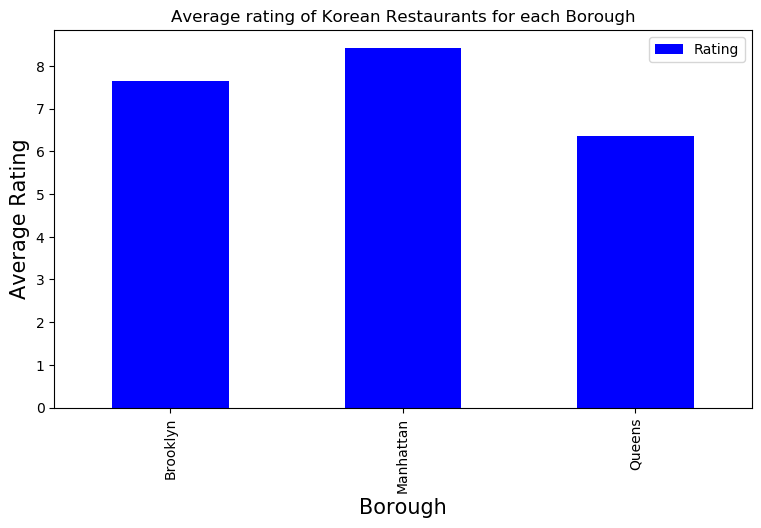

In [53]:
plt.figure(figsize=(9,5), dpi = 100)
plt.title('Average rating of Korean Restaurants for each Borough')
plt.xlabel('Borough', fontsize = 15)
plt.ylabel('Average Rating', fontsize=15)
korean_rest_stats_ny.groupby('Borough').mean()['Rating'].plot(kind='bar', color=clr)
plt.legend()
plt.show()

Find the average rating larger equal than 8.0

In [54]:
ny_neighborhood_stats=ny_neighborhood_stats[ny_neighborhood_stats['Average Rating']>=8.0]
ny_neighborhood_stats

,Neighborhood,Average Rating
2,Clinton,8.400000
4,East Village,8.733333
8,Manhattan Valley,8.000000
9,Midtown South,8.357143
13,Prospect Heights,8.400000
15,South Side,8.400000
16,Sunnyside Gardens,8.000000
17,Tribeca,8.900000
18,West Village,8.300000
19,Williamsburg,8.400000


In [55]:
ny_neighborhood_stats=pd.merge(ny_neighborhood_stats,ny_data, on='Neighborhood')
ny_neighborhood_stats=ny_neighborhood_stats[['Borough','Neighborhood','Latitude','Longitude','Average Rating']]
ny_neighborhood_stats

,Borough,Neighborhood,Latitude,Longitude,Average Rating
0,Manhattan,Clinton,40.759101,-73.996119,8.400000
1,Manhattan,East Village,40.727847,-73.982226,8.733333
2,Manhattan,Manhattan Valley,40.797307,-73.964286,8.000000
3,Manhattan,Midtown South,40.748510,-73.988713,8.357143
4,Brooklyn,Prospect Heights,40.676822,-73.964859,8.400000
5,Brooklyn,South Side,40.710861,-73.958001,8.400000
6,Queens,Sunnyside Gardens,40.745652,-73.918193,8.000000
7,Manhattan,Tribeca,40.721522,-74.010683,8.900000
8,Manhattan,West Village,40.734434,-74.006180,8.300000
9,Brooklyn,Williamsburg,40.707144,-73.958115,8.400000


Create a map and display

In [56]:
ny_map = folium.Map(location=geo_location('New York'), zoom_start=12)
rating = folium.map.FeatureGroup()

for lat, lng, in ny_neighborhood_stats[['Latitude','Longitude']].values:
    rating.add_child(
        folium.CircleMarker(
            [lat, lng],
            radius=10, 
            color='yellow',
            fill=True,
            fill_color='blue',
            fill_opacity=0.6
        )
    )

In [59]:
ny_neighborhood_stats['Label']=ny_neighborhood_stats['Neighborhood']+', '+ny_neighborhood_stats['Borough']+'('+ny_neighborhood_stats['Average Rating'].map(str)+')'
for lat, lng, label in ny_neighborhood_stats[['Latitude','Longitude','Label']].values:
    folium.Marker([lat, lng], popup=label).add_to(ny_map)        
ny_map.add_child(rating)

### Results and Conclusion

Manhattan have the best rated Korean restaurants on average, and Murray Hill in Manhattan has the highest number of Korean Restaurants in all of NY. Despite Queens having the most number of Korean restauratns, the avrerage rating of them are the lowest in all of NY. Brooklyn also has a realtively high average rating on Korean restaurants, just a little bit lower than Manhattan. Based on the above information, I would say that Manhattan and Brooklyn are the best locations for Korean cuisine in NYC. 

If you want to open a new Korean restaurant, I will suggest Brooklyn, because the number of korean restaurants in Brooklyn is the least, and the average rating is relatively high. That means, if you open a new korean restaurant, you will not have a lot of competitors. Finally, I would go to BCD Tofu House in Manhattan for the best Korean food based on 1229 likes.